# BERT LIAR

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/MS983/Datasets/LIAR/

# Import necessary libraries
import tensorflow as tf
from huggingface_hub import hf_hub_download
from transformers import BertTokenizerFast
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn import metrics

# Load LIAR dataset
df = pd.read_csv("liar_dataset.csv")[["statement", "label_binary", "dataset"]].dropna()
texts = df["statement"].tolist()
labels = df["label_binary"].values
dataset = df["dataset"].values

# Tokenize the texts
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
encodings = tokenizer(texts, truncation=True, padding=True, max_length=128)

# Prepare model inputs
ids = np.array(encodings["input_ids"])
mask = np.array(encodings["attention_mask"])
labels = np.array(labels)
segs = np.zeros_like(ids)

# Select test split (dataset == 2)
test_idx = dataset == 2
X_test_ids, X_test_msk, X_test_seg, y_test = (
    ids[test_idx],
    mask[test_idx],
    segs[test_idx],
    labels[test_idx],
)

test_x = {
    "token_ids": X_test_ids,
    "padding_mask": X_test_msk,
    "segment_ids": X_test_seg,
}

# Load the pre-trained model
MODEL_PATH = hf_hub_download(
    repo_id="euansmith9/liar_bert_model", filename="liar_bert.keras"
)
model = tf.keras.models.load_model(MODEL_PATH)

logits = model.predict(test_x, batch_size=32, verbose=1)
logits = np.array(logits).reshape(-1)

p_real = tf.sigmoid(logits).numpy().ravel()            # probability of "real"
p_fake = 1.0 - p_real
probs = np.stack([p_fake, p_real], axis=-1)

/content/drive/MyDrive/MS983/Datasets/LIAR


/usr/local/lib/python3.12/dist-packages/keras/src/saving/serialization_lib.py:734: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 52 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step


In [ ]:
# Evaluate accuracy at different thresholds
margins = np.linspace(0.025, 0.475, 19)

for m in margins:
    lower, upper = 0.5 - m, 0.5 + m

    preds = np.full(y_test.shape, -1)
    preds[p_fake >= upper] = 0  # fake
    preds[p_fake <= lower] = 1  # real

    within = preds != -1
    coverage = within.mean()

    if coverage > 0:
        acc = accuracy_score(y_test[within], preds[within])
        prec_macro = precision_score(y_test[within], preds[within], average="macro")
        rec_macro  = recall_score(y_test[within], preds[within], average="macro")
        f1_macro   = f1_score(y_test[within], preds[within], average="macro")
    else:
        acc = prec_fake = rec_fake = f1_fake = float("nan")
        prec_macro = rec_macro = f1_macro = float("nan")
    print(
        f"Thresholds=({lower:.3f},{upper:.3f}) -> "
        f"Prec={prec_macro:.4f}, Rec={rec_macro:.4f}, F1={f1_macro:.4f}, "
        f"Coverage={coverage:.2f}"
    )



Thresholds=(0.475,0.525) -> Prec=0.6333, Rec=0.6260, F1=0.6268, Coverage=0.91
Thresholds=(0.450,0.550) -> Prec=0.6521, Rec=0.6412, F1=0.6427, Coverage=0.81
Thresholds=(0.425,0.575) -> Prec=0.6658, Rec=0.6482, F1=0.6500, Coverage=0.70
Thresholds=(0.400,0.600) -> Prec=0.6810, Rec=0.6518, F1=0.6547, Coverage=0.61
Thresholds=(0.375,0.625) -> Prec=0.6902, Rec=0.6460, F1=0.6507, Coverage=0.52
Thresholds=(0.350,0.650) -> Prec=0.7097, Rec=0.6441, F1=0.6496, Coverage=0.43
Thresholds=(0.325,0.675) -> Prec=0.7053, Rec=0.6254, F1=0.6309, Coverage=0.35
Thresholds=(0.300,0.700) -> Prec=0.7272, Rec=0.5978, F1=0.6000, Coverage=0.27
Thresholds=(0.275,0.725) -> Prec=0.6849, Rec=0.5491, F1=0.5299, Coverage=0.19
Thresholds=(0.250,0.750) -> Prec=0.9062, Rec=0.6029, F1=0.6190, Coverage=0.12
Thresholds=(0.225,0.775) -> Prec=0.9426, Rec=0.6500, F1=0.7003, Coverage=0.05
Thresholds=(0.200,0.800) -> Prec=0.8958, Rec=0.5833, F1=0.5847, Coverage=0.02
Thresholds=(0.175,0.825) -> Prec=0.3333, Rec=0.5000, F1=0.4000, 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Final evaluation at chosen thresholds
lower, upper = 0.425, 0.575

preds = np.full(y_test.shape, -1)
preds[p_fake >= upper] = 0   # fake
preds[p_fake <= lower] = 1   # real

within = preds != -1
print(f"Coverage: {within.mean():.2f}")

print(classification_report(y_test[within], preds[within]))


Coverage: 0.70
              precision    recall  f1-score   support

           0       0.64      0.49      0.56       368
           1       0.69      0.80      0.74       522

    accuracy                           0.68       890
   macro avg       0.67      0.65      0.65       890
weighted avg       0.67      0.68      0.67       890



Coverage: 0.70


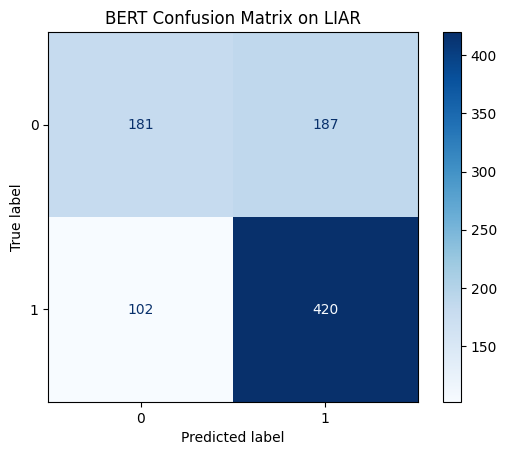

In [14]:
print(f"Coverage: {within.mean():.2f}")
confusion_matrix = confusion_matrix(y_test[within], preds[within])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
cm_display.plot(cmap="Blues", values_format='d')
plt.title("BERT Confusion Matrix on LIAR")
plt.show()